# HW 1-1: Deep vs. Shallow
## CPSC 8430
## Adam Patyk

In [2]:
import math
import torch
import numpy as np

### Part 1: Simulate a Function

In [3]:
# model definitions
from common.DNN_Models import ShallowNetwork, ModerateNetwork, DeepNetwork

## -----------------------------------------------
## Create models and validate number of parameters
## -----------------------------------------------

models = []
models.append(ShallowNetwork())
models.append(ModerateNetwork())
models.append(DeepNetwork())

for i in range(len(models)):
  num_params = sum(p.numel() for p in models[i].parameters())
  print(f'Model {i} parameters: {num_params}')

Model 0 parameters: 601
Model 1 parameters: 599
Model 2 parameters: 601


In [5]:
from torch.utils.data import DataLoader
# Torch dataset for function data
from common.FunctionDataset import FunctionDataset

## ------------------------
## Create data for training
## ------------------------

num_data_points = 100
range_min = 0
range_max = 1

# create data points from function e^x * sin^2(3*pi*x) over a range
raw_data = FunctionDataset(num_data_points, range_min, range_max)

# z-score standardize training data
training_data = raw_data.standardize()

# create data loader for batch training
training_loader = DataLoader(training_data, batch_size=1, shuffle=True)
print('Data ready.')

Data ready.


In [4]:
## ----------------------------------------------------
## Train models [est. time: ~1 hour with 10,000 epochs]
## ----------------------------------------------------

epochs = 10000

# train each model
training_loss = []
for i in range(len(models)):
  loss_arr = []
  models[i].zero_grad()

  print(f'Training model {i}:')

  for epoch in range(epochs):
    model_loss = models[i].train(training_loader)
    loss_arr.append(model_loss)
    if epoch % (epochs/10) == (epochs/10)-1: # print updates 10 times
      print(f'Epoch: {epoch+1}/{epochs} \tLoss: {model_loss:.6f}')

  training_loss.append(loss_arr)
  torch.save(models[i].state_dict(), f'results/1/func_models/model{i}.pt')

# save results to .txt file
np.savetxt('results/1/func_models/training_loss.txt', np.array(training_loss))

Training model 0:
Epoch: 1000/10000 	Loss: 0.013191
Epoch: 2000/10000 	Loss: 0.020308
Epoch: 3000/10000 	Loss: 0.018590
Epoch: 4000/10000 	Loss: 0.015562
Epoch: 5000/10000 	Loss: 0.008067
Epoch: 6000/10000 	Loss: 0.007029
Epoch: 7000/10000 	Loss: 0.016487
Epoch: 8000/10000 	Loss: 0.007162
Epoch: 9000/10000 	Loss: 0.007474
Epoch: 10000/10000 	Loss: 0.008898
Training model 1:
Epoch: 1000/10000 	Loss: 0.007933
Epoch: 2000/10000 	Loss: 0.006603
Epoch: 3000/10000 	Loss: 0.007567
Epoch: 4000/10000 	Loss: 0.007502
Epoch: 5000/10000 	Loss: 0.007144
Epoch: 6000/10000 	Loss: 0.003029
Epoch: 7000/10000 	Loss: 0.004867
Epoch: 8000/10000 	Loss: 0.004738
Epoch: 9000/10000 	Loss: 0.004085
Epoch: 10000/10000 	Loss: 0.003770
Training model 2:
Epoch: 1000/10000 	Loss: 0.242496
Epoch: 2000/10000 	Loss: 0.240891
Epoch: 3000/10000 	Loss: 0.240589
Epoch: 4000/10000 	Loss: 0.239094
Epoch: 5000/10000 	Loss: 0.239485
Epoch: 6000/10000 	Loss: 0.249647
Epoch: 7000/10000 	Loss: 0.005728
Epoch: 8000/10000 	Loss: 0

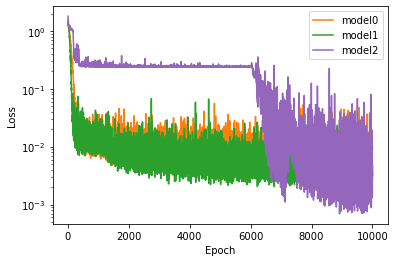

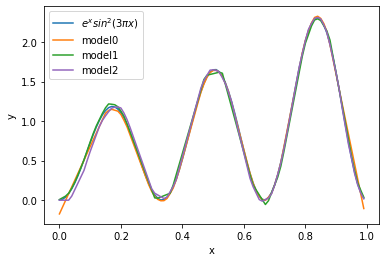

In [8]:
import matplotlib.pyplot as plt

## ------------
## Plot results
## ------------

def inverse_standardize(data, mean, stddev):
    data = data * stddev + mean
    return data

colors = ['tab:orange', 'tab:green', 'tab:purple']

# load model parameters from previous training
for i in range(len(models)):
  saved_model = torch.load(f'results/1/func_models/model{i}.pt')
  models[i].load_state_dict(saved_model)

# load loss from previous training
training_loss = np.loadtxt('results/1/func_models/training_loss.txt')

# z-score standardize training data
testing_data = raw_data.standardize()

# plot loss over epochs for all models
for i in range(len(models)):
    plt.plot(np.arange(0, epochs), training_loss[i], color=colors[i], label=f'model{i}')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig(f'results/1/func_models/fig_loss_comparison.pdf')
plt.show()

# plot values from final model vs. ground truth function
plt.plot(raw_data[:, 0], raw_data[:, 1], label=r'$e^xsin^2(3 \pi x)$')
for i in range(len(models)):
    func_vals = []
    for datum in testing_data:
        input = datum[0].reshape(-1)
        output = models[i](input)
        output = inverse_standardize(output, raw_data.mean, raw_data.stddev)
        func_vals.append(output)
    plt.plot(raw_data[:, 0], func_vals, color=colors[i],label=f'model{i}')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('results/1/func_models/fig_output_comparison.pdf')
plt.show()

### Part 2: Train on an Actual Task

In [10]:
# model definitions and hyperparameters
from common.MNIST_CNN_Models import ShallowCNN, ModerateCNN, DeepCNN

## -------------
## Create models
## -------------

models = []
models.append(ShallowCNN())
models.append(ModerateCNN())
models.append(DeepCNN())

print('Models ready.')


Models ready.


In [3]:
import torchvision
from torchvision import datasets, transforms

## ------------------------------------------------
## Load data, normalized (mean = 0.5, stddev = 0.5)
## ------------------------------------------------

img_batch_size = 32

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

training_set = torchvision.datasets.MNIST(root='./data/', train=True, 
                                            download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=img_batch_size,
                                          shuffle=True)

testing_set = torchvision.datasets.MNIST(root='./data/', train=False,
                                            download=True, transform=transform)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=img_batch_size,
                                         shuffle=False)

print('Data ready.')

Data ready.


In [5]:
## -----------------------------------------------------------
## Train & test models [est. time: ~3.5 hours with 150 epochs]
## -----------------------------------------------------------

epochs = 150

training_loss = []
training_acc = []

for i in range(len(models)):
  loss_arr = []
  acc_arr = []

  models[i].zero_grad()

  print(f'Training model {i}:')

  for epoch in range(epochs):
    # train
    model_loss = models[i].train(training_loader)
    loss_arr.append(model_loss)
    # test
    model_acc, _ = models[i].test(training_loader)
    acc_arr.append(model_acc)
    # print updates 10 times
    if epoch % (epochs/10) == (epochs/10)-1: 
      print(f'Epoch: {epoch+1}/{epochs} \tLoss: {model_loss:.6f} \tAccuracy: {model_acc:.2f}')
  
  training_loss.append(loss_arr)
  training_acc.append(acc_arr)
  torch.save(models[i].state_dict(), f'results/1/mnist_models/model{i}.pt')

# save results to .txt files
np.savetxt('results/1/mnist_models/training_loss.txt', np.array(training_loss))
np.savetxt('results/1/mnist_models/training_acc.txt', np.array(training_acc))

Training model 0:
Epoch: 15/150 	Loss: 0.002816 	Accuracy: 99.98
Epoch: 30/150 	Loss: 0.000138 	Accuracy: 100.00
Epoch: 45/150 	Loss: 0.000075 	Accuracy: 100.00
Epoch: 60/150 	Loss: 0.000051 	Accuracy: 100.00
Epoch: 75/150 	Loss: 0.000038 	Accuracy: 100.00
Epoch: 90/150 	Loss: 0.000030 	Accuracy: 100.00
Epoch: 105/150 	Loss: 0.000025 	Accuracy: 100.00
Epoch: 120/150 	Loss: 0.000021 	Accuracy: 100.00
Epoch: 135/150 	Loss: 0.000018 	Accuracy: 100.00
Epoch: 150/150 	Loss: 0.000016 	Accuracy: 100.00
Training model 1:
Epoch: 15/150 	Loss: 0.008418 	Accuracy: 99.90
Epoch: 30/150 	Loss: 0.000048 	Accuracy: 100.00
Epoch: 45/150 	Loss: 0.000019 	Accuracy: 100.00
Epoch: 60/150 	Loss: 0.000012 	Accuracy: 100.00
Epoch: 75/150 	Loss: 0.000009 	Accuracy: 100.00
Epoch: 90/150 	Loss: 0.000007 	Accuracy: 100.00
Epoch: 105/150 	Loss: 0.000006 	Accuracy: 100.00
Epoch: 120/150 	Loss: 0.000005 	Accuracy: 100.00
Epoch: 135/150 	Loss: 0.000005 	Accuracy: 100.00
Epoch: 150/150 	Loss: 0.000004 	Accuracy: 100.0

In [6]:
## -----------
## Test models
## -----------

for i in range(len(models)):
  print(f'Testing model {i}:')
  model_acc, _ = models[i].test(testing_loader)
  print(f'Accuracy: {model_acc:.2f}')

Testing model 0:
Accuracy: 98.64
Testing model 1:
Accuracy: 99.13
Testing model 2:
Accuracy: 98.71


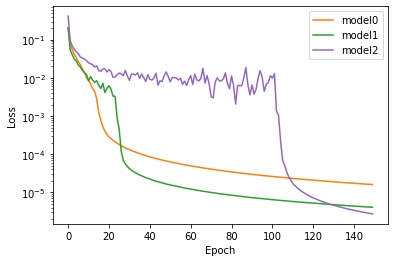

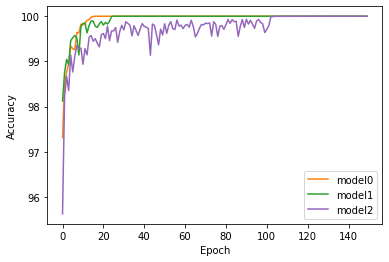

In [15]:
import matplotlib.pyplot as plt

## ------------
## Plot results
## ------------

colors = ['tab:orange', 'tab:green', 'tab:purple']

# load model parameters from previous training
for i in range(len(models)):
  saved_model = torch.load(f'results/1/mnist_models/model{i}.pt')
  models[i].load_state_dict(saved_model)

# load results
training_loss = np.loadtxt('results/1/mnist_models/training_loss.txt')
training_acc = np.loadtxt('results/1/mnist_models/training_acc.txt')

# plot training loss over epochs
for i in range(len(models)):
  plt.plot(np.arange(0, epochs), training_loss[i], color=colors[i], label=f'model{i}')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig('results/1/mnist_models/fig_training_loss_comparison.pdf')
plt.show()

# plot training accuracy over epochs
for i in range(len(models)):
  plt.plot(np.arange(0, epochs), training_acc[i], color=colors[i], label=f'model{i}')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('results/1/mnist_models/fig_training_acc_comparison.pdf')
plt.show()